# Тестовое задание "ChemTech"

## 0. импорт бибилиотек

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
import os, re, sys, gc, pickle, time
from collections import defaultdict

from sklearn.model_selection import GridSearchCV, cross_val_score,\
                                    KFold, train_test_split, cross_validate, ParameterGrid,\
                                    cross_validate, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin,  clone
# пайплайн
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin,  clone
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, OneHotEncoder

# дамми-регрессор
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import HuberRegressor
import time
from sklearn.feature_selection import SelectFromModel
import shutil
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error,\
                            mean_squared_log_error, median_absolute_error, r2_score

# нейронные сети 
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

## 0. вспомогательные функции

In [2]:
class SklearnHelperColumnSelector(BaseEstimator, TransformerMixin):
    '''выбирает колонки, отпавляемые в пайплайн'''
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.columns]

class SklearnHelperFeatureSelector(BaseEstimator, TransformerMixin):
    ''' Отбор признаков '''
    def __init__(self, model, cv, scoring, show_progress):
        self.model = model
        self.cv = cv
        self.scoring = scoring
        self.show_progress = show_progress
    def fit(self, X, y=None):
        assert (isinstance(X, np.ndarray)) or (X.getformat() == 'csc')
        _X = X.copy()
        cv_scores = []
        for i in tqdm_notebook(range(_X.shape[1])):
            try:
                _X_curr = _X[:, i].toarray().reshape(-1,1)
            except:
                _X_curr = _X[:, i].reshape(-1,1)                
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()            
            cv_scores.append(mean_cv_score)
            
        order = np.argsort(cv_scores)[::-1]
        to_drop_before, best_features, best_cv_score = [], [order[0]], -np.inf
        for i in tqdm_notebook(order[1:]):
            curr_features = best_features+[i]
            _X_curr = _X[:, curr_features]
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
            if mean_cv_score>best_cv_score:
                best_cv_score = mean_cv_score
                best_features = curr_features
                if self.show_progress:
                    print('new best score = {:.10f}'.format(best_cv_score))
            else:
                to_drop_before.append(i)
        while True:
            to_drop_after = []
            for i in tqdm_notebook(to_drop_before):
                curr_features = best_features+[i]
                _X_curr = _X[:, curr_features]
                mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
                if mean_cv_score>best_cv_score:
                    best_cv_score = mean_cv_score
                    best_features = curr_features
                    if self.show_progress:
                        print('new best score = {:.10f}'.format(best_cv_score))
                else:
                    to_drop_after.append(i)
            if to_drop_before == to_drop_after:
                break
            else:
                to_drop_before = to_drop_after  
        self.best_features_ = best_features
        self.best_score_ = best_cv_score
    def transform(self, _X):
        return _X[:, self.best_features_]
    
class SklearnHelperRegressorHPTuner(BaseEstimator, TransformerMixin):    
    def __init__(self, model, cv, scoring):
        self.model = model
        self.cv = cv
        self.scoring = scoring
    def info(self):
        pass
    def fit(self, X, y=None):
        assert (isinstance(X, np.ndarray)) or (X.getformat() == 'csc')
        best_estimator_ = clone(self.model)
        best_params = {}
        if type(self.model).__name__ == 'LGBMRegressor':     
            init_params = self.model.get_params()
            bp = {'n_estimators':init_params['n_estimators'],\
                  'random_state':init_params['random_state'],\
                  'n_jobs':init_params['n_jobs']}
            
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'n_estimators':[10], 'n_jobs':[-1], 'random_state':[SEED],\
                                            'max_depth':np.arange(2, 21).tolist(),\
                                            'num_leaves':[32, 64, 128, 256, 512, 1024],\
                                            'min_child_samples':[20, 50]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)
            best_estimator_ = best_estimator_.set_params(**best_params)
            
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'subsample':np.linspace(.1, 1, 10),\
                                            'colsample_bytree':np.linspace(.1, 1, 10)},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)
            best_params['n_estimators'] = bp['n_estimators']
            best_params['random_state'] = bp['random_state']
            best_params['n_jobs'] = bp['n_jobs']
            best_estimator_ = best_estimator_.set_params(**best_params)
            
            learning_rates = [.005,.006, .007, .008, .009,\
                              .01, .02, .03, .04, .05, .06, .07, .08, .09,\
                              .1, .2, .3, .4, .5]
            best_score = -np.inf
            for lr in tqdm_notebook(learning_rates):
                best_params['learning_rate'] = lr
                lgb_curr = best_estimator_.set_params(**best_params)
                mean_cv_score = cross_val_score(lgb_curr, X, y, cv = self.cv, scoring = self.scoring).mean()
                if mean_cv_score>best_score:
                    best_score = mean_cv_score
                    best_lr = lr
                else:
                    break
            best_score = -np.inf
            for lr in tqdm_notebook(np.linspace(best_lr-.009,best_lr+.009, 50)):
                best_params['learning_rate'] = lr
                lgb_curr = best_estimator_.set_params(**best_params)
                mean_cv_score = cross_val_score(lgb_curr, X, y, cv = self.cv, scoring = self.scoring).mean()
                if mean_cv_score>best_score:
                    best_score = mean_cv_score
                    self.best_estimator_ = lgb_curr
                else:
                    break
            self.best_score_ =  best_score                   
        elif type(self.model).__name__ == 'XGBRegressor': 
            init_params = best_estimator_.get_params()
            bp = {'n_estimators':init_params['n_estimators'],\
                  'random_state':init_params['random_state'],\
                  'n_jobs':init_params['n_jobs']}
            
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'n_estimators':[10], 'n_jobs':[-1], 'random_state':[SEED],\
                                            'max_depth':np.arange(2, 21).tolist(),\
                                            'min_child_weight':[20, 50]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)            
            best_estimator_ = best_estimator_.set_params(**best_params)
            
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'subsample':[.5, .6, .7, .8, .9, 1],\
                                            'colsample_bytree':[.5, .6, .7, .8, .9, 1]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)
            best_params['n_estimators'] = bp['n_estimators']
            best_params['random_state'] = bp['random_state']
            best_params['n_jobs'] = bp['n_jobs']
            best_estimator_ = best_estimator_.set_params(**best_params)            
            
            learning_rates = [.005,.006, .007, .008, .009,\
                              .01, .02, .03, .04, .05, .06, .07, .08, .09,\
                              .1, .2, .3, .4, .5]
            best_score = -np.inf
            for lr in tqdm_notebook(learning_rates):
                best_params['learning_rate'] = lr
                xgb_curr = best_estimator_.set_params(**best_params)
                mean_cv_score = cross_val_score(xgb_curr, X, y, cv = self.cv, scoring = self.scoring).mean()
                if mean_cv_score>best_score:
                    best_score = mean_cv_score
                    best_lr = lr                    
                else:
                    break
            best_score = -np.inf
            for lr in tqdm_notebook(np.linspace(best_lr-.009,best_lr+.009, 50)):
                best_params['learning_rate'] = lr
                xgb_curr = best_estimator_.set_params(**best_params)
                mean_cv_score = cross_val_score(xgb_curr, X, y, cv = self.cv, scoring = self.scoring).mean()
                if mean_cv_score>best_score:
                    best_score = mean_cv_score
                    self.best_estimator_ = xgb_curr                    
                else:
                    break
            self.best_score_ = best_score                    
        elif type(self.model).__name__ in ('DecisionTreeRegressor', 'ExtraTreeRegressor'):
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'max_depth':np.arange(7, 41), 'min_samples_leaf':[2, 20, 200]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)
            self.best_estimator_ = best_estimator_.set_params(**best_params)
            self.best_score_ = gs.best_score_
        elif type(self.model).__name__ in ('RandomForestRegressor', 'ExtraTreesRegressor'):
            init_params = self.model.get_params()
            bp = {'n_estimators':init_params['n_estimators'],\
                  'random_state':init_params['random_state'],\
                  'n_jobs':init_params['n_jobs']}
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'max_depth':np.arange(5, 21),'min_samples_leaf':[2, 20],\
                                            'n_estimators':[10], 'n_jobs':[-1], 'random_state':[bp['random_state']]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)
            best_params['n_estimators'] = bp['n_estimators']
            best_params['random_state'] = bp['random_state']
            best_params['n_jobs'] = bp['n_jobs']
            self.best_estimator_ = best_estimator_.set_params(**best_params)
            self.best_score_ = cross_val_score(self.best_estimator_,\
                                               X, y,\
                                               cv = self.cv, scoring=self.scoring, n_jobs=-1).mean()
        elif type(self.model).__name__ in ('Ridge', 'Lasso'):            
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'alpha':[.001, .002, .003, .004, .005,\
                                                     .01, .02, .03, .04, .05, .06, .07, .08, .09,\
                                                     .1, .2, .3, .4, .5, .6, .7, .8, .9,\
                                                     1, 2, 3, 4, 5],\
                                           'normalize':[True]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            self.best_estimator_ = gs.best_estimator_
            self.best_score_ = gs.best_score_
            
        elif type(self.model).__name__ == 'LinearSVR':
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'C':[.5, 1, 2, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100,\
                                                 150, 200, 250, 300, 350, 400, 450, 500]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            self.best_estimator_ = gs.best_estimator_
            self.best_score_ = gs.best_score_
            
        elif type(self.model).__name__ == 'KNeighborsRegressor':
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'n_neighbors':range(2, 11)},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            self.best_estimator_ = gs.best_estimator_
            self.best_score_ = gs.best_score_
            
        self.best_estimator_.fit(X, y) 
        try:
            self.coef_imp_ = self.best_estimator_.coef_.flatten()
        except:
            self.coef_imp_ = self.best_estimator_.feature_importances_.flatten()        
        return self
    def predict(self, X):
        return self.best_estimator_.predict(X) 
    
class SklearnHelperTargetEncoder(BaseEstimator, TransformerMixin):
    ''' Кодирование категорий с помощью целевой переменной '''
    def __init__(self, n_iter, n_folds, min_samples_leaf, seed):
        self.n_iter = n_iter
        self.n_folds = n_folds
        self.min_samples_leaf = min_samples_leaf
        self.seed = seed
    def fit(self, X, y=None):
        self.y_mean = y.mean()
        _df_tr = pd.concat([X, y], 1)
        target_col = _df_tr.columns[-1]
        to_encode = _df_tr.columns[:-1]
        
        L_tr = []        
        self.L_d_encs = []
        for i in tqdm_notebook(range(self.n_iter)): 
            enc_tr = pd.DataFrame(index = _df_tr.index, columns = to_encode).fillna(0.0)
            for col in to_encode:
                for tr_idx, val_idx in KFold(self.n_folds, shuffle = True,random_state = self.seed+i)\
                                       .split(_df_tr):                    
                    grp = _df_tr.iloc[tr_idx].groupby(col)[target_col].agg({'mean', 'count'})                    
                    d_enc = grp[grp['count']>=self.min_samples_leaf]['mean'].to_dict()
                    self.L_d_encs.append((col, d_enc))
                    to_enc_tr =_df_tr.iloc[val_idx]                    
                    enc_tr.loc[to_enc_tr.index, col] = to_enc_tr[col].map(d_enc)                   
            L_tr.append(enc_tr)    
            
        self.enc_tr =  pd.concat(L_tr, 1)
        self._df_tr = _df_tr
        return self    
    def transform(self, X):
        if np.all(X.values == self._df_tr.values):
            return self.enc_tr
        else:
            df_enc = pd.DataFrame(index = X.index, columns=X.columns).fillna(0.0)
            for feat, d in tqdm_notebook(self.L_d_encs):
                df_enc.loc[:, feat] += X[feat].map(d) / self.n_iter
            return df_enc
        
class SklearnHelperStackingRegressor(BaseEstimator, TransformerMixin):
    def __init__(self, L_base_models, nfolds, seed, path_to_folder):
        self.L_base_models = L_base_models
        self.nfolds = nfolds
        self.seed = seed
        self.path_to_folder=path_to_folder
        
        if os.path.isdir(self.path_to_folder):
            shutil.rmtree(self.path_to_folder)
            os.makedirs(self.path_to_folder)
        else:
            os.makedirs(self.path_to_folder) 
            
    def fit(self, L_X, y=None):
        L_Z = []
        self.nrows = L_X[0].shape[0] 
        self.y_mean = y.mean()
        # классический стекинг
        for i, (model, X) in tqdm_notebook(enumerate(zip(self.L_base_models, L_X)),\
                                              total = len(self.L_base_models)):
            current_seed=i+self.seed
            kf = KFold(self.nfolds, random_state= current_seed, shuffle = True)
            
            
            
            
            # пустые таблицы
            Z_tr = np.zeros((y.shape[0], 1))            

            # запускаем фолдинг
            for j, (tr_idx, val_idx) in tqdm_notebook(enumerate(kf.split(X, y)),\
                                                      total = self.nfolds):
                model.fit(X[tr_idx], y[tr_idx])
                
                filename = os.path.join(self.path_to_folder, f'model_{i+1}_{j+1}.pickle')
                with open(filename, 'wb') as f:
                    pickle.dump((model, i, j), f)
                    
                Z_tr[val_idx, 0] = model.predict(X[val_idx])                

            L_Z.append(Z_tr)
            
        self.Z = np.column_stack(L_Z)        
        return self
    
    def predict(self, L_X):
        if self.nrows == L_X[0].shape[0]:
            return self.Z     
        else:  
            folder_with_models = os.listdir(self.path_to_folder)
            L = []
            for file in tqdm_notebook(folder_with_models):    
                with open(os.path.join(self.path_to_folder, file), 'rb') as f:
                    model, i, j =pickle.load(f)
                L.append(model.predict(L_X[i])) 
            XX_meta = np.column_stack(L)
            X_meta = np.column_stack([arr.mean(1) for arr in np.array_split(XX_meta, len(self.L_base_models), axis = 1)])
            
            return X_meta

# 0. константы

In [3]:
PATH_TO_DATA = r'C:\Users\Sergey\anaconda3\Scripts\ChemTech_test_task'
SEED = 13
FILL_NA = -9999
TEST_SIZE = .1
IMP_N_REPEATS = 100

# пути к обученным пайплайнам
PATH_TO_TRANSFORMERS = r'D:\chemtech_ppl_transformers'
if os.path.isdir(PATH_TO_TRANSFORMERS):
    shutil.rmtree(PATH_TO_TRANSFORMERS)
    os.makedirs(PATH_TO_TRANSFORMERS)
else:
    os.makedirs(PATH_TO_TRANSFORMERS) 
    
# валидация
KF = KFold(5, random_state = SEED, shuffle = True)

## 1. первичный анализ

In [4]:
df_tr = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_200k.csv'), parse_dates=[0], index_col=[0]).sort_index()

In [5]:
target_columns = ['target1', 'target2', 'target3', 'target4']

In [6]:
targets_nan_shares = df_tr[target_columns].isna().mean()
for target_name, nan_share in targets_nan_shares.items():
    print('{}: доля np.nan равна {}'.format(target_name, nan_share))

target1: доля np.nan равна 4.5e-05
target2: доля np.nan равна 4.5e-05
target3: доля np.nan равна 4.5e-05
target4: доля np.nan равна 4.5e-05


In [7]:
df_tr[df_tr[target_columns].isna().any(1)][target_columns]

,target1,target2,target3,target4
2016-08-18 00:00:00,NaN,NaN,NaN,NaN
2016-08-18 00:01:00,NaN,NaN,NaN,NaN
2016-08-18 00:02:00,NaN,NaN,NaN,NaN
2016-08-18 00:03:00,NaN,NaN,NaN,NaN
2016-08-18 00:04:00,NaN,NaN,NaN,NaN
2016-08-18 00:05:00,NaN,NaN,NaN,NaN
2016-08-18 00:06:00,NaN,NaN,NaN,NaN
2016-08-18 00:07:00,NaN,NaN,NaN,NaN
2016-08-18 00:08:00,NaN,NaN,NaN,NaN


#### Вывод:
* в целевых признаках данные отсутствуют в 9 строках, удалим их 

In [8]:
# выбрасываем np.nan из таргетов
df_tr = df_tr.dropna(subset=target_columns)

In [9]:
df_is_nan = df_tr.drop(target_columns, 1).isna()

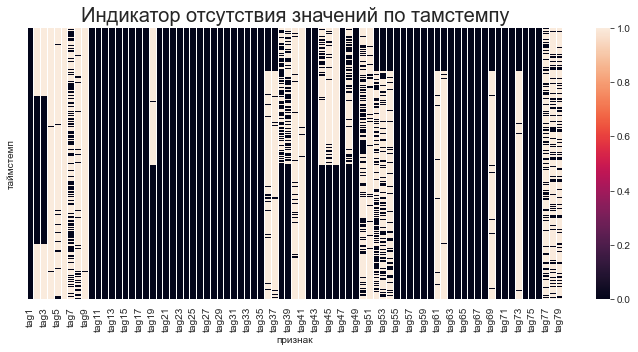

In [10]:
fig = plt.figure(figsize = (12, 5))
hm = sns.heatmap(df_is_nan)
hm.set_title('Индикатор отсутствия значений по тамстемпу', fontsize= 20)
hm.set_xlabel('признак')
hm.set_ylabel('таймстемп')
hm.set(yticklabels=[])
plt.show()

#### Выводы:
* характеры распределения таймстемпов с пропущенными значениями можно разделить на 3 группы
* 1) значения отсутвуют регулярно на всем временном интервале 
* 2) значения отсутвуют случайно на всем временном интервале 
* 3) значения отсутсвуют до или после опредееленного таймстемпа
* 4) значения отсутствуют на определенном отрезке таймстемпа

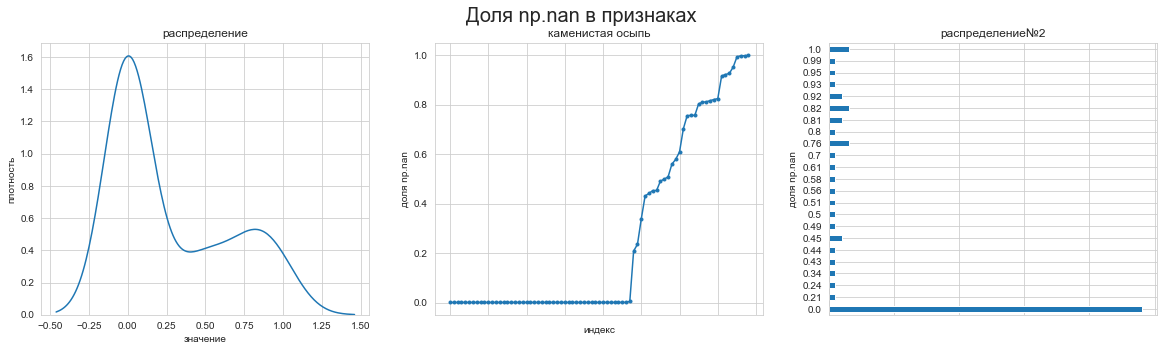

In [11]:
plt.figure(figsize = (20, 5))
plt.suptitle('Доля np.nan в признаках', fontsize = 20)

ax1 = plt.subplot(1, 3, 1)
kde_plot = sns.kdeplot(df_is_nan.mean())
kde_plot.set_title('распределение')
kde_plot.set_xlabel('значение')
kde_plot.set_ylabel('плотность')

ax2 = plt.subplot(1, 3, 2)
elbow_plot = df_is_nan.mean().sort_values().plot(ax = ax2, marker ='.')
elbow_plot.set_title('каменистая осыпь')
elbow_plot.set_xlabel('индекс')
elbow_plot.set_ylabel('доля np.nan')
elbow_plot.set(xticklabels=[])

ax3 = plt.subplot(1, 3, 3)
bar_plot = df_is_nan.mean().round(2).value_counts().sort_index().plot(kind = 'barh')
bar_plot.set_title('распределение№2')
bar_plot.set(xticklabels=[])
bar_plot.set_ylabel('доля np.nan')
plt.show()

#### Выводы:
* 1) около половины признаков не имеют отсутсвующих значений
* 2) в остальных признаках доля np.nan варьируется от .2 до ~1
* 3) наиболее часто значения отвутствуют в ~76% строк

In [12]:
# признаки, таргеты
features_tr = df_tr.drop(target_columns, 1)
targets_tr = df_tr[target_columns]

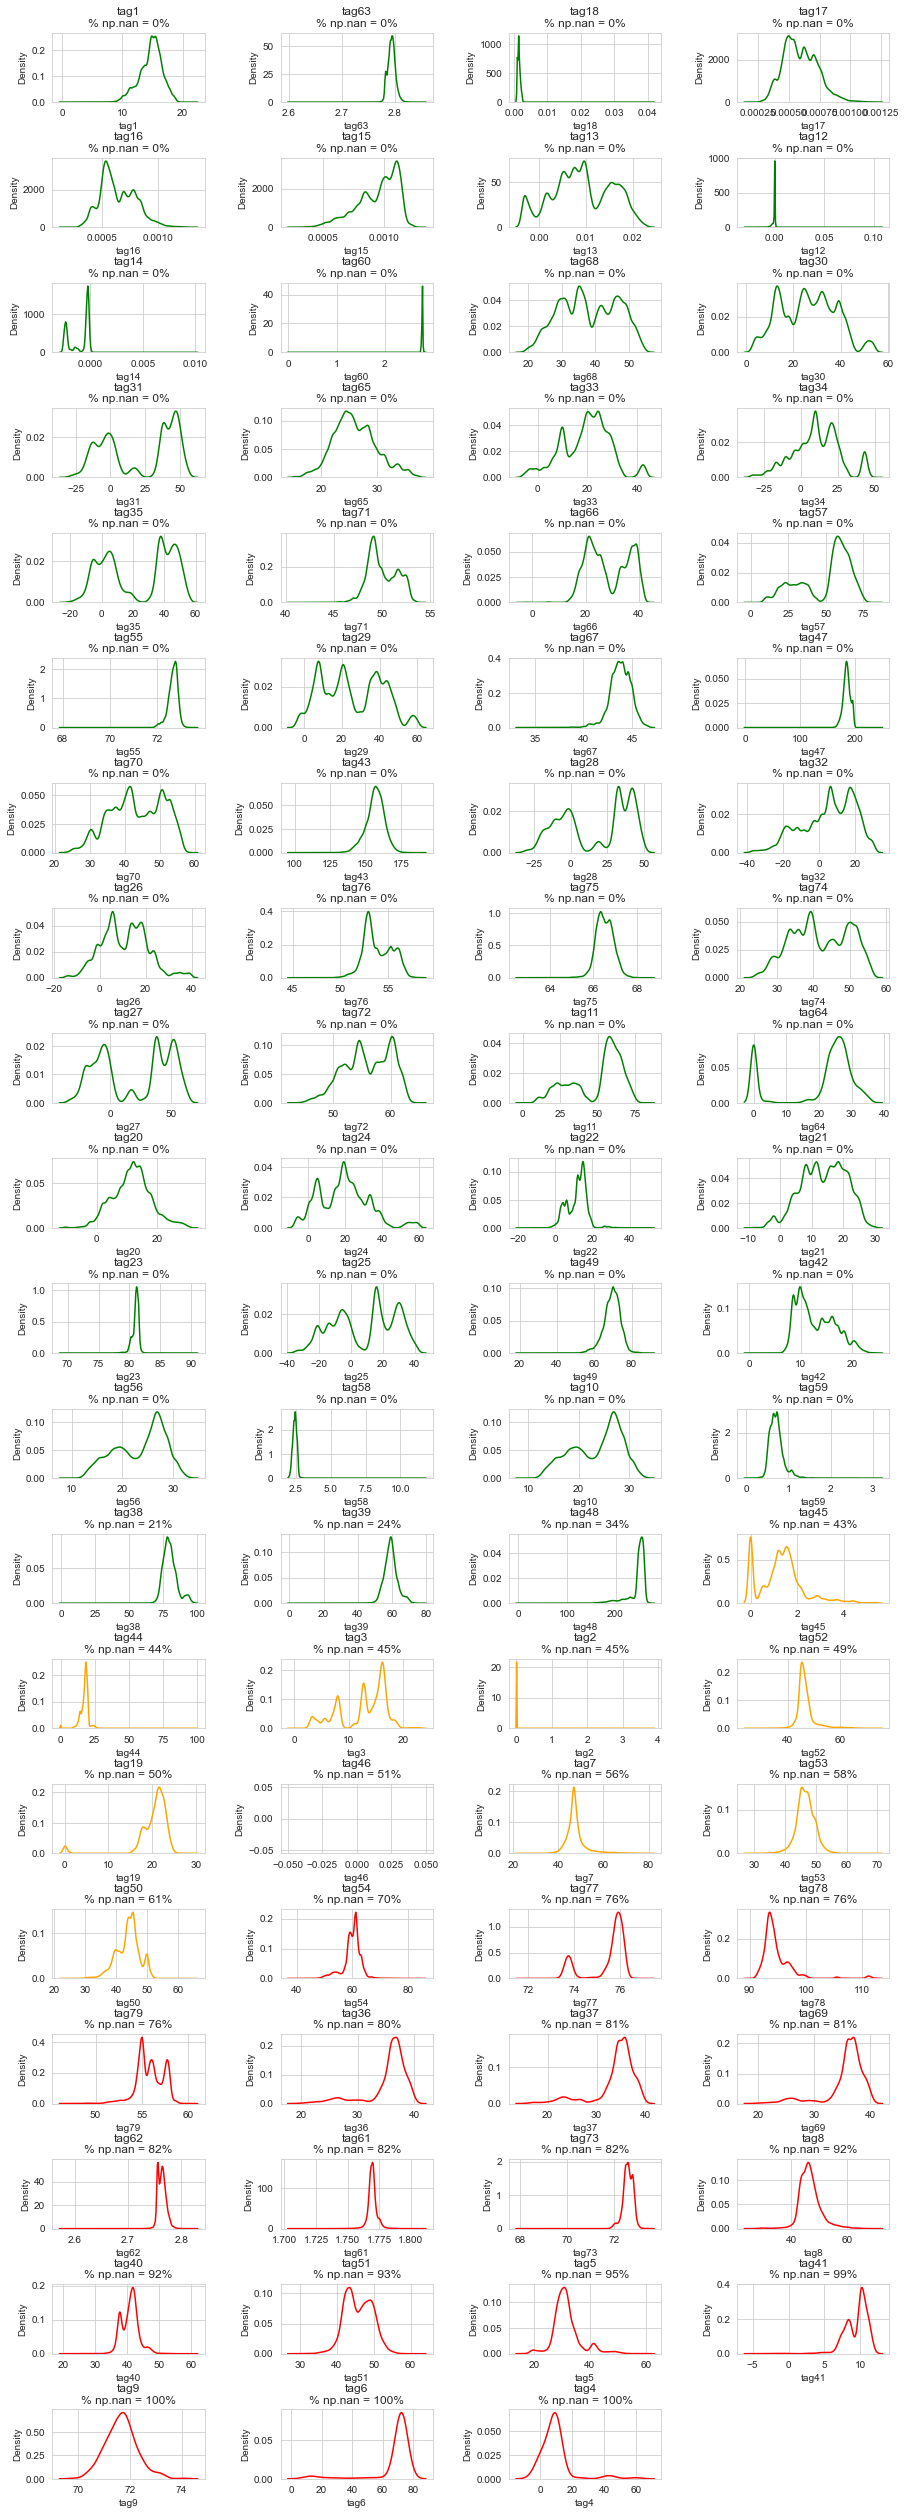

In [13]:
fig = plt.figure(figsize = (15, 45))

nfeats = features_tr.shape[1]
ncols = 4
nrows = np.int32(np.ceil(nfeats / ncols))

# для каждого признака
for i, feature in tqdm_notebook(enumerate(features_tr.isna().mean().sort_values().index),\
                                total = nfeats):
    ser = features_tr[feature]
    
    # считаем долю np.nan
    nan_share = ser.isna().mean()
    
    if nan_share<.4:
        color = 'green'
    elif (nan_share>=.4) & (nan_share<.7):
        color = 'orange'
    else:
        color = 'red'        
    
    plt.subplot(nrows, ncols, i+1)
    sns.kdeplot(ser, color=color)
    plt.title('{}\n% np.nan = {:.0%}'.format(feature, nan_share))    
    
plt.subplots_adjust(hspace = .8, wspace = .5)

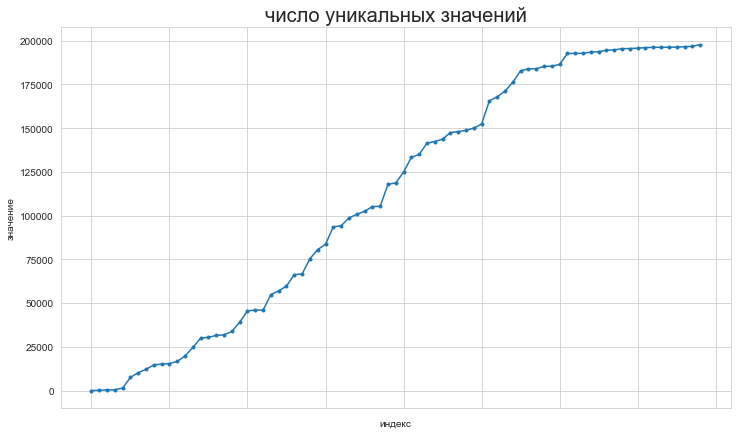

In [14]:
# число уникальных значений
plot_nuniques = features_tr.nunique().sort_values().plot(marker ='.', figsize = (12, 7))
plot_nuniques.set_title('число уникальных значений', fontsize = 20)
plot_nuniques.set_xlabel('индекс')
plot_nuniques.set_ylabel('значение')
plot_nuniques.set(xticklabels=[])
plt.show()

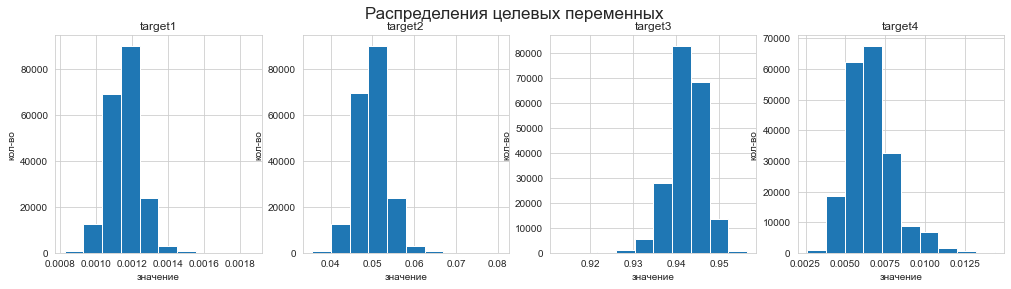

In [15]:
fig = plt.figure(figsize = (17, 4))
plt.suptitle('Распределения целевых переменных', fontsize = 17)
for i, col in enumerate(targets_tr.columns):
    plt.subplot(1, 4, i+1)
    targets_tr[col].hist()
    plt.title(col)
    plt.xlabel('значение')
    plt.ylabel('кол-во')

#### Выводы:
* 1. целевые переменные имеют тяжелые хвосты
* 2. лучше использовать такую метрику качества, которая наименеесильно зависит от аномальных значений (например mae)

In [16]:
# к-ф корреляции
targets_corr = targets_tr.corr()
targets_corr = targets_corr.where(np.triu(np.ones_like(targets_corr).astype(np.bool), k=1))

features_corr = features_tr.corr()
features_corr = features_corr.where(np.triu(np.ones_like(features_corr).astype(np.bool), k=1))

corr_w_target1, corr_w_target2, corr_w_target3, corr_w_target4 = \
    [features_tr.corrwith(targets_tr[col]) for col in targets_tr.columns]

In [17]:
targets_corr

,target1,target2,target3,target4
target1,NaN,0.999999,-0.930867,-0.073910
target2,NaN,NaN,-0.930863,-0.073923
target3,NaN,NaN,NaN,-0.295557
target4,NaN,NaN,NaN,NaN


#### Выводы:
* похоже, target2 - это зашумленный target1

In [18]:
corr_uniques = pd.Series(features_corr.values.flatten()).dropna()

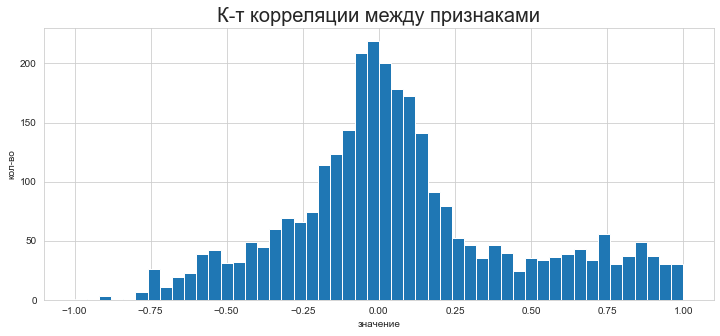

In [19]:
corr_uniques.hist(bins=50, figsize = (12, 5))
plt.title('К-т корреляции между признаками',fontsize = 20)
plt.xlabel('значение')
plt.ylabel('кол-во')
plt.show()

#### Выводы:
* 1. присутвует мультиколлинеарность
* 2. степень линейной связи между признаками варьируется от очень слабой до очень сильной
* 3. между большинством признаков линейной связи практичеки нет

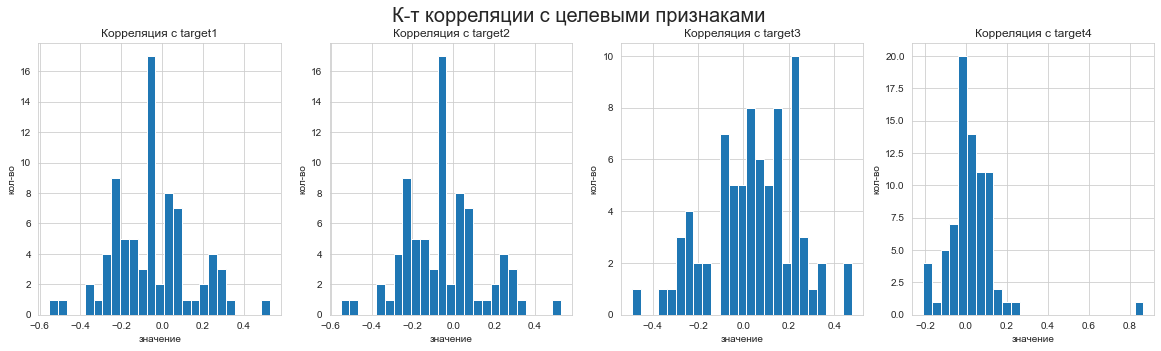

In [20]:
BINS = 25

fig = plt.figure(figsize = (20, 5))
plt.suptitle('К-т корреляции с целевыми признаками', fontsize = 20)

ax1 = plt.subplot(1, 4, 1)
corr_w_target1.hist(bins=BINS, ax = ax1)
ax1.set_title('Корреляция с target1')
ax1.set_xlabel('значение')
ax1.set_ylabel('кол-во')

ax2 = plt.subplot(1, 4, 2)
corr_w_target2.hist(bins=BINS, ax = ax2)
ax2.set_title('Корреляция с target2')
ax2.set_xlabel('значение')
ax2.set_ylabel('кол-во')

ax3 = plt.subplot(1, 4, 3)
corr_w_target3.hist(bins=BINS, ax = ax3)
ax3.set_title('Корреляция с target3')
ax3.set_xlabel('значение')
ax3.set_ylabel('кол-во')

ax4 = plt.subplot(1, 4, 4)
corr_w_target4.hist(bins=BINS, ax = ax4)
ax4.set_title('Корреляция с target4')
ax4.set_xlabel('значение')
ax4.set_ylabel('кол-во')
plt.show()

In [21]:
features_tr.corrwith(targets_tr['target4']).abs().sort_values(ascending = False).head()

tag59    0.865138
tag6     0.257247
tag44    0.210767
tag43    0.186662
tag10    0.186425
dtype: float64

#### Выводы:
* к-т корр между tag59 и target4 равен ~0.87

## 2. моделирование

### 2.1. признаки, целевые переменные

In [22]:
# тергеты
Y1_TR = targets_tr['target1']
Y2_TR = targets_tr['target2']
Y3_TR = targets_tr['target3']
Y4_TR = targets_tr['target4']

nuniques_TR= features_tr.nunique()
# признаки
X_TR = features_tr[nuniques_TR[nuniques_TR!=1].index]
all_features = X_TR.columns

### 2.2. тренировочные, отложенные выборки, целевые переменные, метрики качества

In [23]:
# тренировочная, отложенная части
X1_tr, X1_ho, y1_tr, y1_ho = train_test_split(X_TR, Y1_TR, test_size = TEST_SIZE, shuffle = True, random_state = SEED)
X2_tr, X2_ho, y2_tr, y2_ho = train_test_split(X_TR, Y2_TR, test_size = TEST_SIZE, shuffle = True, random_state = SEED)
X3_tr, X3_ho, y3_tr, y3_ho = train_test_split(X_TR, Y3_TR, test_size = TEST_SIZE, shuffle = True, random_state = SEED)
X4_tr, X4_ho, y4_tr, y4_ho = train_test_split(X_TR, Y4_TR, test_size = TEST_SIZE, shuffle = True, random_state = SEED)

# списки с признаками, таргетами, метриками
L_X_tr, L_X_ho = [X1_tr, X2_tr, X3_tr, X4_tr], [X1_ho, X2_ho, X3_ho, X4_ho]
L_y_tr, L_y_ho = [y1_tr, y2_tr, y3_tr, y4_tr], [y1_ho, y2_ho, y3_ho, y4_ho]
L_scoring_names = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
L_y_names = ['y1', 'y2', 'y3', 'y4']
L_scoring_funcs = [mean_absolute_error, mean_squared_error, r2_score]

### 2.3. выполняем пайплайны

In [24]:
%%time

L_feature_names = []
L_XX = []
L_cvAB = []
L_importances = []
L_baselines = []

for y_name, X_tr, X_ho, y_tr, y_ho in tqdm_notebook(zip(L_y_names, L_X_tr, L_X_ho,L_y_tr, L_y_ho),\
                                                       total =len(L_X_tr)):    
    for scoring, scoring_func in tqdm_notebook(zip(L_scoring_names, L_scoring_funcs),\
                                                   total =len(L_scoring_funcs)):   
        
        # бейзлайн        
        mean_cv_baseline = cross_val_score(DummyRegressor('mean'),\
                                           X_tr, y_tr,\
                                           cv = KF, scoring = scoring).mean()
        L_baselines.append((y_name, scoring, mean_cv_baseline))
        
        # пайплайн
        ppl_raw = Pipeline([('get_features', SklearnHelperColumnSelector(all_features)),\
                            ('scale', MinMaxScaler()),\
                            ('select_features',SklearnHelperFeatureSelector(\
                                                    model = LGBMRegressor(n_jobs=-1,random_state = SEED),\
                                                    cv = KF,  scoring = scoring,
                                                    show_progress = False))])
        ppl_raw.fit(X_tr, y_tr)
        x_tr = ppl_raw.transform(X_tr)
        x_ho = ppl_raw.transform(X_ho)        
        
        # названия отобранных признаков
        L_feature_names.append(all_features[ppl_raw.steps[-1][-1].best_features_])
        # отобранные признаки
        L_XX.append((y_name, scoring, x_tr, x_ho))        
        
        # оптимизация lightgbm
        lgb_tuner = SklearnHelperRegressorHPTuner(\
                    model = LGBMRegressor(n_jobs=-1, random_state = SEED),\
                    cv = KF,\
                    scoring = scoring)
        lgb_tuner.fit(x_tr, y_tr)
        
        # экспортируем пайплайн и финальную модель
        with open(os.path.join(PATH_TO_TRANSFORMERS,f'ppl_raw_{y_name}_{scoring}.pickle'), 'wb') as f:
            pickle.dump((ppl_raw, lgb_tuner), f)
            
        mean_cv_score = np.abs(lgb_tuner.best_score_)
        ho_score = scoring_func(y_ho, lgb_tuner.predict(x_ho))        
        
        # метрики
        L_cvAB.append((y_name, scoring, mean_cv_score, ho_score))
        
        # важности признаков
        lgb_reg = LGBMRegressor(n_jobs=-1, n_estimators=20)
        lgb_reg.fit(x_tr, y_tr)
        perm_imp = permutation_importance(lgb_reg, x_ho, y_ho,
                                          n_repeats=IMP_N_REPEATS,
                                          random_state=SEED, n_jobs=-1)
        L_importances.append(perm_imp['importances'])
        
        
with open('L_feature_names.pickle', 'wb') as f:
    pickle.dump(L_feature_names, f)
with open('L_XX.pickle', 'wb') as f:
    pickle.dump(L_XX, f)
with open('L_cvAB.pickle', 'wb') as f:
    pickle.dump(L_cvAB, f)
with open('L_importances.pickle', 'wb') as f:
    pickle.dump(L_importances, f)
with open('L_baselines.pickle', 'wb') as f:
    pickle.dump(L_baselines, f)

In [66]:
with open('L_feature_names.pickle', 'rb') as f:
    L_feature_names=pickle.load(f)
with open('L_XX.pickle', 'rb') as f:
    L_XX = pickle.load(f)
with open('L_cvAB.pickle', 'rb') as f:
    L_cvAB = pickle.load(f)
with open('L_importances.pickle', 'rb') as f:
    L_importances = pickle.load(f)
with open('L_baselines.pickle', 'rb') as f:
    L_baselines=pickle.load(f)

### 2.4. анализ результатов

In [67]:
# метрика на валидации и на отложенной для целевых признаков y1, y2, y3, y4
cvAB = pd.DataFrame.from_records(L_cvAB, columns = ['target', 'metric', 'cv', 'ho'])         

In [68]:
cvAB

,target,metric,cv,ho
0,y1,neg_mean_absolute_error,4.822746e-06,4.662841e-06
1,y1,neg_mean_squared_error,5.052918e-11,4.566357e-11
2,y1,r2,9.930957e-01,9.936838e-01
3,y2,neg_mean_absolute_error,2.178825e-04,2.078902e-04
4,y2,neg_mean_squared_error,9.214707e-08,8.175898e-08
5,y2,r2,9.932228e-01,9.939126e-01
6,y3,neg_mean_absolute_error,2.127302e-04,2.027252e-04
7,y3,neg_mean_squared_error,8.613889e-08,8.318170e-08
8,y3,r2,9.944495e-01,9.945463e-01
9,y4,neg_mean_absolute_error,1.959203e-05,1.823808e-05


In [69]:
lgb_reg = LGBMRegressor(n_jobs=-1, random_state = SEED)
N_SAMPLES=1000
SAMPLE_SIZE = 10
ALPHA = .05

In [299]:
for idxs, target_name in zip(([0,1,2], [3, 4, 5], [6, 7, 8], [9, 10, 11]),\
                             ('y1', 'y2', 'y3', 'y4')):                                      
    print(str.upper(target_name))
    L_y_preds = []
    for idx in idxs:
        _X_tr = L_XX[idx][2]    
        y_pred = cross_val_predict(lgb_reg, _X_tr, y_tr, cv = KF)
        L_y_preds.append(y_pred)
    df_y_predictions = pd.DataFrame(np.column_stack(L_y_preds), columns = ['mae', 'mse', 'r2'])
    D_y_sample_means = defaultdict(list)
    for _ in range(N_SAMPLES):
        np.random.seed(_)
        ser = df_y_predictions.sample(SAMPLE_SIZE).mean()
        for k, v in ser.items():
            D_y_sample_means[k].append(v)
            
    if stats.ttest_ind(D_y1_sample_means['mae'], D_y1_sample_means['mse'])[1] >= ALPHA:
        print('MAE VS MSE | средние одинаковые на уровне значимости 95%')
    else:
        print('MAE VS MSE | средние разные на уровне значимости 95%')    

    if stats.ttest_ind(D_y1_sample_means['mae'], D_y1_sample_means['r2'])[1] >= ALPHA:
        print('MAE VS R2  | средние одинаковые на уровне значимости 95%')
    else:
        print('MAE VS R2  | средние разные на уровне значимости 95%') 

    if stats.ttest_ind(D_y1_sample_means['mse'], D_y1_sample_means['r2'])[1] >= ALPHA:
        print('MSE VS MSE | средние одинаковые на уровне значимости 95%')
    else:
        print('MSE VS MSE | средние разные на уровне значимости 95%')
        
    print('------------------------------------------------------------------')

Y1
MAE VS MSE | средние одинаковые на уровне значимости 95%
MAE VS R2  | средние одинаковые на уровне значимости 95%
MSE VS MSE | средние одинаковые на уровне значимости 95%
------------------------------------------------------------------
Y2
MAE VS MSE | средние одинаковые на уровне значимости 95%
MAE VS R2  | средние одинаковые на уровне значимости 95%
MSE VS MSE | средние одинаковые на уровне значимости 95%
------------------------------------------------------------------
Y3
MAE VS MSE | средние одинаковые на уровне значимости 95%
MAE VS R2  | средние одинаковые на уровне значимости 95%
MSE VS MSE | средние одинаковые на уровне значимости 95%
------------------------------------------------------------------
Y4
MAE VS MSE | средние одинаковые на уровне значимости 95%
MAE VS R2  | средние одинаковые на уровне значимости 95%
MSE VS MSE | средние одинаковые на уровне значимости 95%
------------------------------------------------------------------


#### Выводы:
* 1. r2 достигает ~99%
* 2. разниц в средних значениях предсказаний, сделанных моделями, оптимизирующими разные метрики, нет на уровне значимости 95%

In [253]:
D_df_imps = defaultdict(list)
for importances, columm_names,(target, metric) in zip(L_importances,\
                                                      L_feature_names,\
                                                      cvAB[['target', 'metric']].values):
    nm = '.'.join([target, metric])
    df_imp = pd.DataFrame(importances).T
    df_imp.columns = columm_names
    df_imp = df_imp[df_imp.mean().sort_values(ascending = False).index]
    D_df_imps[target].append(df_imp.mean().to_frame('perm_imp.'+nm))    

In [256]:
top_10_features_y1 = pd.concat(D_df_imps['y1'],1).mean(1).sort_values(ascending = False).head(10).index
top_10_features_y2 = pd.concat(D_df_imps['y2'],1).mean(1).sort_values(ascending = False).head(10).index
top_10_features_y3 = pd.concat(D_df_imps['y3'],1).mean(1).sort_values(ascending = False).head(10).index
top_10_features_y4 = pd.concat(D_df_imps['y4'],1).mean(1).sort_values(ascending = False).head(10).index

In [268]:
df_feature_ranks = pd.DataFrame(np.column_stack([top_10_features_y1, top_10_features_y2, top_10_features_y3, top_10_features_y4]),\
            columns = ['y1', 'y2', 'y3', 'y4'])
df_feature_ranks.index.name = 'importances_rank'

In [304]:
df_feature_ranks

,y1,y2,y3,y4
importances_rank,,,,
0,tag49,tag49,tag49,tag59
1,tag75,tag75,tag59,tag74
2,tag42,tag42,tag75,tag72
3,tag67,tag67,tag42,tag26
4,tag58,tag58,tag67,tag21
5,tag43,tag43,tag58,tag42
6,tag71,tag71,tag43,tag28
7,tag63,tag63,tag71,tag68
8,tag66,tag66,tag63,tag27


### 2.5. предсказания для тестовой части 
* разниц в средних не выявлено
* смешаем предсказания моделей, оптимизировавших разные метрики

In [45]:
df_te = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_data_100k.csv'), parse_dates=[0], index_col=[0])

In [313]:
D_predictions_test = defaultdict(list)
for filename in tqdm_notebook(os.listdir(PATH_TO_TRANSFORMERS)):
    with open(os.path.join(PATH_TO_TRANSFORMERS,filename), 'rb') as f:
        ppl_raw, lgb_tuner = pickle.load(f)
    D_predictions_test[filename.split('_')[2]].append(lgb_tuner.predict(ppl_raw.transform(df_te)))    

In [333]:
df_predictions_te = pd.DataFrame(np.column_stack([np.column_stack(D_predictions_test[k]).mean(1) for k in D_predictions_test.keys()]),\
            columns = ['y1', 'y2', 'y3', 'y4'])

In [339]:
df_predictions_te.sample(10)

,y1,y2,y3,y4
21573,0.001146,0.048974,0.942324,0.007583
6252,0.001227,0.052951,0.939451,0.006139
69515,0.001204,0.051005,0.942410,0.005015
79754,0.001117,0.048016,0.946071,0.004663
22023,0.001220,0.050991,0.941052,0.005991
28232,0.001183,0.051712,0.942211,0.006271
59881,0.001357,0.058531,0.937401,0.004301
24110,0.001219,0.052672,0.939265,0.006605
76662,0.001245,0.054761,0.940038,0.004754
7019,0.001251,0.054558,0.937931,0.005732


### 2.6. бонус: построение ансамбля
* я провел лишь валидацию и выявил переобучение, если оно было
* предсказаний для теста не делал

In [26]:
with open('L_feature_names.pickle', 'rb') as f:
    L_feature_names=pickle.load(f)
with open('L_XX.pickle', 'rb') as f:
    L_XX = pickle.load(f)
with open('L_cvAB.pickle', 'rb') as f:
    L_cvAB = pickle.load(f)
with open('L_importances.pickle', 'rb') as f:
    L_importances = pickle.load(f)
with open('L_baselines.pickle', 'rb') as f:
    L_baselines=pickle.load(f)

In [27]:
# базовые модели
L_base_models= [Ridge(), ExtraTreeRegressor()]

In [28]:
# стекинг
lgb_reg = LGBMRegressor(n_jobs=-1,random_state=SEED)
stacking_reg= SklearnHelperStackingRegressor(L_base_models, 
                               nfolds = 20,
                               seed = SEED,\
                               path_to_folder=r'D:\chemtech_fitted_models')

In [29]:
# признаки (для таргетов и метрик)
D_features = defaultdict(list)
for el in L_XX:    
    D_features[el[0]].append((el[2],el[3]))

In [1]:
L_cvAB_ensemble = []
j=0
for k,  v in tqdm_notebook(D_features.items()):  
    for metric_idx in range(len(v)):

        X_tr = D_features[k][metric_idx][0]
        X_ho= D_features[k][metric_idx][1]

        imputer = SimpleImputer(strategy ='median')
        X_tr = imputer.fit_transform(X_tr)
        X_ho = imputer.transform(X_ho)

        stacking_reg.fit([X_tr, X_tr, X_tr], L_y_tr[j])

        X_meta_tr = np.hstack([D_features[k][metric_idx][0], stacking_reg.predict([X_tr, X_tr])])
        X_meta_ho = np.hstack([D_features[k][metric_idx][1], stacking_reg.predict([X_ho, X_ho])])


        cv_results = cross_validate(lgb_reg, X_meta_tr, L_y_tr[j],\
                       cv = KF,scoring = L_scoring_names[metric_idx], return_estimator = True)
        mean_cv_score = np.abs(cv_results['test_score'].mean())
        lgb_reg.fit(X_meta_tr, L_y_tr[j])
        ho_score= L_scoring_funcs[metric_idx](L_y_ho[j], lgb_reg.predict(X_meta_ho))

        L_cvAB_ensemble.append((k, L_scoring_names[metric_idx], mean_cv_score, ho_score))
        
    j+=1

In [61]:
cvAB_ensemble = pd.DataFrame(L_cvAB_ensemble, columns = ['target', 'metric', 'cv', 'ho'])

In [77]:
cvAB_final = pd.concat([cvAB_ensemble[['target', 'metric']], \
                       (cvAB_ensemble[['cv', 'ho']] < cvAB[['cv', 'ho']]).add_suffix('_stacking_improvement')], 1)

In [78]:
cvAB_final

,target,metric,cv_stacking_improvement,ho_stacking_improvement
0,y1,neg_mean_absolute_error,False,True
1,y1,neg_mean_squared_error,False,True
2,y1,r2,True,False
3,y2,neg_mean_absolute_error,False,True
4,y2,neg_mean_squared_error,False,True
5,y2,r2,True,False
6,y3,neg_mean_absolute_error,False,True
7,y3,neg_mean_squared_error,False,True
8,y3,r2,True,False
9,y4,neg_mean_absolute_error,True,True
